# Partially denoise items in test set

To get a better sense of how we do on different length structures, we take test set items, and ask our model to denoise partially noised versions of them. We can then compare overall reconstruction error as a function of length.

In [21]:
import os, sys
import tempfile
from pathlib import Path
from typing import *

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import torch
from torch import nn
from torch.utils.data import default_collate
from huggingface_hub import snapshot_download

from foldingdiff import sampling, modelling, tmalign, utils
from foldingdiff import angles_and_coords as ac

sys.path.append("/home/wukevin/projects/protdiff/bin")
from sample import build_datasets

PLOT_DIR = (Path(os.getcwd()) / '../plots').resolve()
assert PLOT_DIR.is_dir()
PLOT_DIR

PosixPath('/home/wukevin/projects/protdiff/plots')

In [2]:
model_path = Path(snapshot_download("wukevin/foldingdiff_cath"))
model = modelling.BertForDiffusion.from_dir(model_path).to(torch.device('cuda:3'))
model_path

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Using time embedding: GaussianFourierProjection()
Using loss: [functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f1e870dcee0>, beta=0.3141592653589793)]


PosixPath('/home/wukevin/.cache/huggingface/hub/models--wukevin--foldingdiff_cath/snapshots/98d77b1e68468db5ca03cdba1c0a90f2a2a33edc')

In [3]:
train_dset, valid_dset, test_dset = build_datasets(model_path, load_actual=True)
len(train_dset), len(valid_dset), len(test_dset)

(24316, 3039, 3040)

In [5]:
@torch.no_grad()
def get_reconstruction_error(model: nn.Module, dset=test_dset, noise_timesteps:int=750, bs:int=512) -> np.ndarray:
    """
    Get the reconstruction error when adding <noise_timesteps> noise to the idx-th
    item in the dataset.
    """
    device = next(model.parameters()).device
    model.eval()

    recont_angle_sets = []
    truth_angle_sets = []
    truth_pdb_files = []
    for idx_batch in tqdm(utils.seq_to_groups(list(range(len(dset))), bs)):
        batch = default_collate(
            [
                {k: v.to(device) for k, v in dset.__getitem__(idx, use_t_val=noise_timesteps).items()} 
                for idx in idx_batch
            ]
        )
        img = batch['corrupted'].clone()
        assert img.ndim == 3

        # Run the diffusion model for noise_timesteps steps
        for i in reversed(range(0, noise_timesteps)):
            img = sampling.p_sample(
                model=model,
                x=img,
                t=torch.full((len(idx_batch),), fill_value=i, dtype=torch.long).to(device),
                seq_lens=batch['lengths'],
                t_index=i,
                betas=dset.alpha_beta_terms['betas'],
            )

            img = utils.modulo_with_wrapped_range(img)

        # Finished reconstruction, subset to lengths and add to running list
        for i, l in enumerate(batch['lengths'].squeeze()):
            recont_angle_sets.append(
                pd.DataFrame(img[i, :l].cpu().numpy(), columns=ac.EXHAUSTIVE_ANGLES)
            )
            truth_angle_sets.append(
                pd.DataFrame(batch['angles'][i, :l].cpu().numpy(), columns=ac.EXHAUSTIVE_ANGLES)
            )
            truth_pdb_files.append(dset.filenames[i])
        
        # break  # For debug

    # Get the reconstruction error as a TM score
    scores = []
    coord_scores = []
    for reconst_angles, truth_angles, truth_pdb in zip(recont_angle_sets, truth_angle_sets, truth_pdb_files):
        with tempfile.TemporaryDirectory() as tmpdir:
            truth_path = Path(tmpdir) / "truth.pdb"
            reconst_path = Path(tmpdir) / "reconst.pdb"

            truth_pdb = ac.create_new_chain_nerf(str(truth_path), truth_angles)
            reconst_pdb = ac.create_new_chain_nerf(str(reconst_path), reconst_angles)

            # Calculate wrt the truth angles
            score = tmalign.run_tmalign(reconst_pdb, truth_pdb)
            scores.append(score)

            score_coord = tmalign.run_tmalign(reconst_pdb, truth_pdb)
            coord_scores.append(score_coord)
    return np.array(scores), np.array(coord_scores)

test_reconst_tm_scores, test_reconst_coords_tm_scores = get_reconstruction_error(model=model, dset=test_dset)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
test_struc_lengths = np.array([test_dset[i]['lengths'].item() for i in range(len(test_dset))])
# test_struc_lengths = np.array([test_dset[i]['lengths'].item() for i in range(512)])
test_struc_lengths

array([128,  98, 128, ..., 128, 128,  96])

In [7]:
coarse_bins = np.arange(40, 130 + 1, 20)
test_struc_lengths_coarse = np.digitize(test_struc_lengths, bins=coarse_bins)
test_struc_lengths_coarse

array([5, 3, 5, ..., 5, 5, 3])

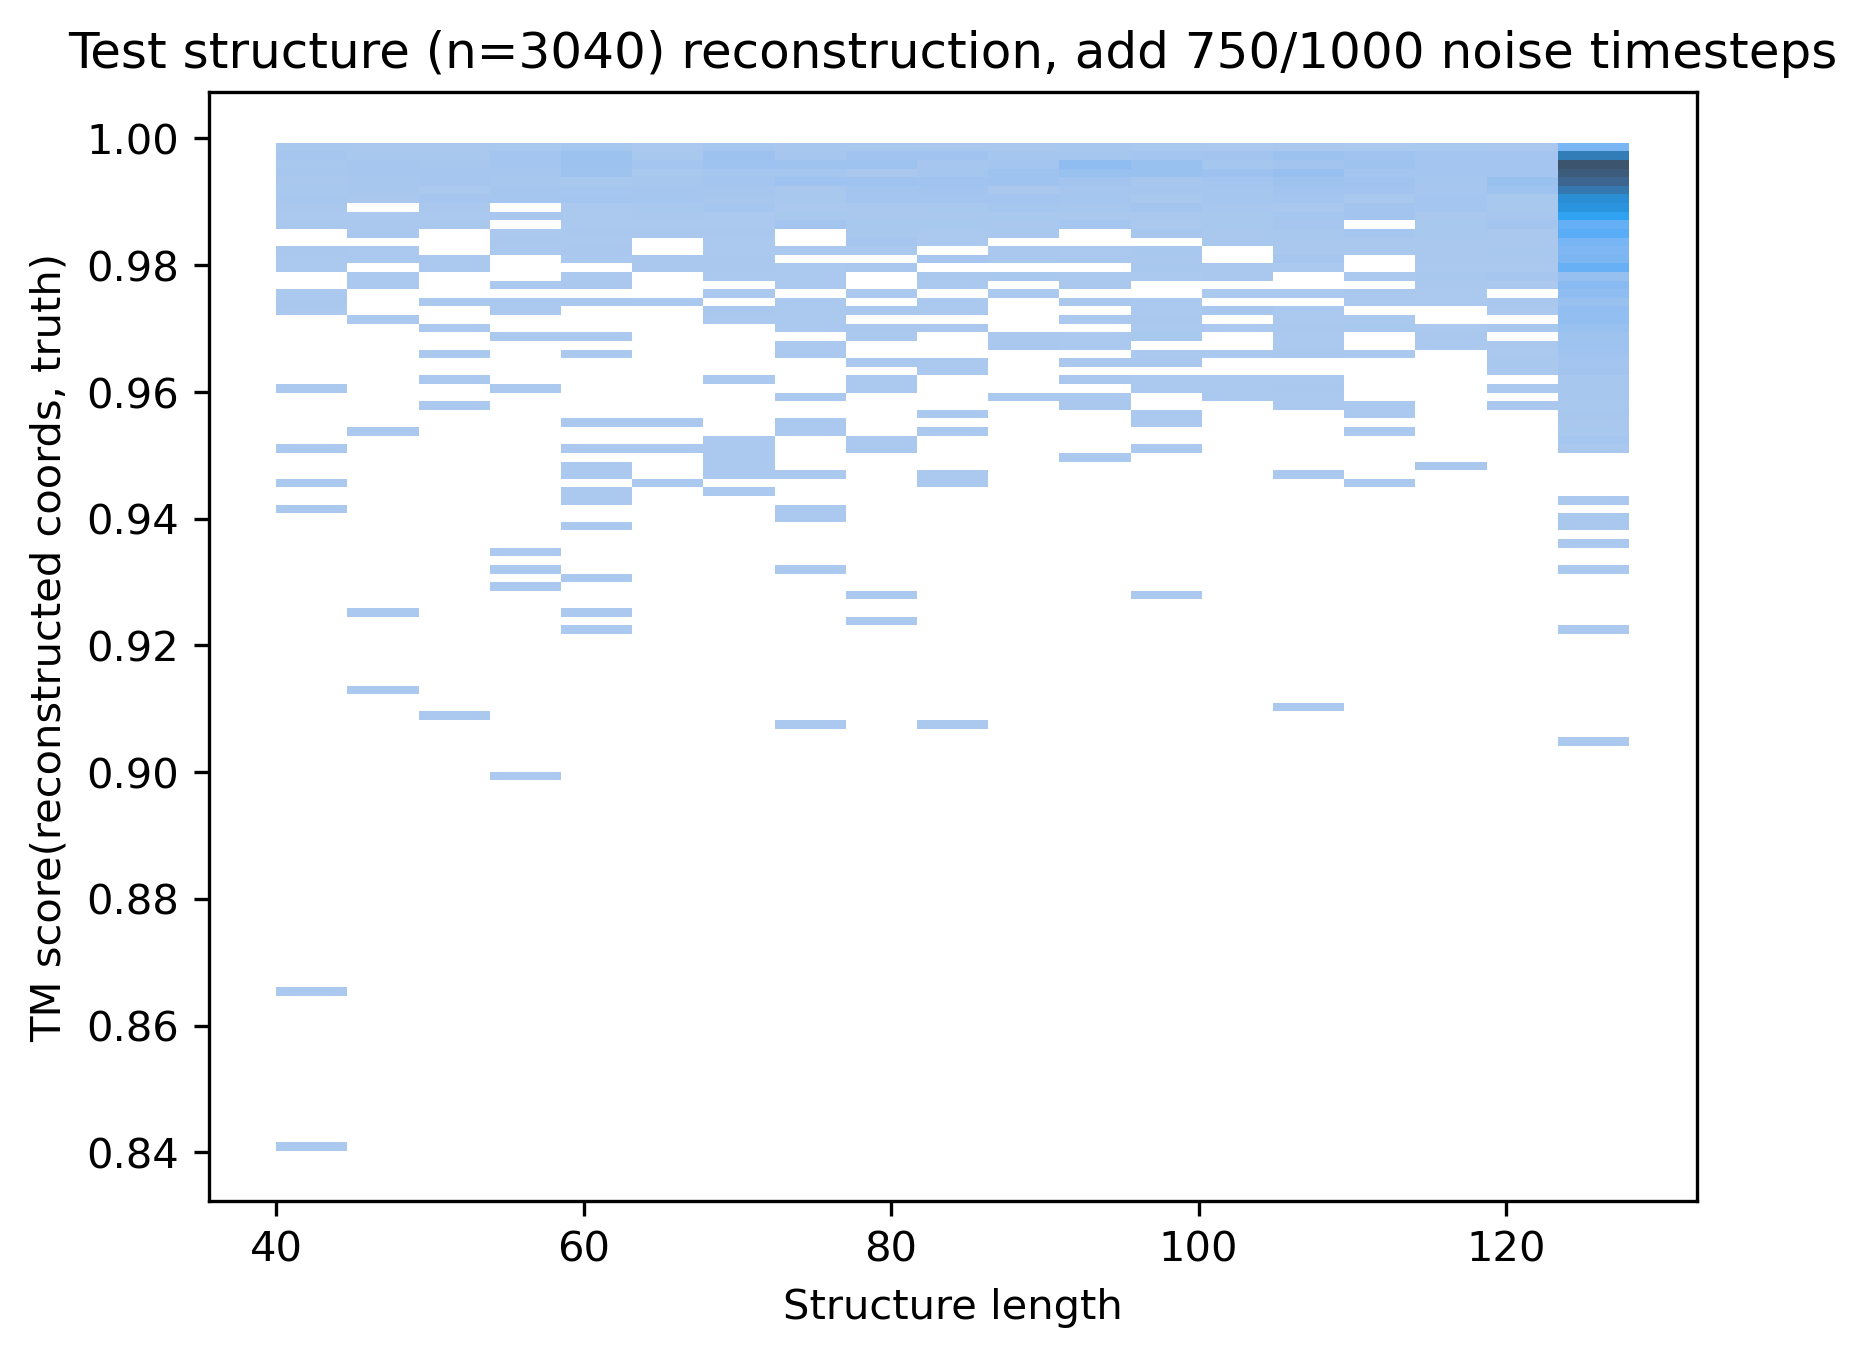

In [23]:
fig, ax = plt.subplots(dpi=300)
sns.histplot(x=test_struc_lengths, y=test_reconst_coords_tm_scores, ax=ax)
ax.set(
    xlabel="Structure length",
    ylabel="TM score(reconstructed coords, truth)",
    title=f"Test structure (n={len(test_dset)}) reconstruction, add 750/1000 noise timesteps",
)
fig.savefig(PLOT_DIR / "test_reconst_vs_length.pdf", bbox_inches='tight')
fig.show()

In [17]:
stats.spearmanr(test_struc_lengths, test_reconst_tm_scores)

SpearmanrResult(correlation=-0.028923898398110385, pvalue=0.11083944340939811)